In [155]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

import time

import chromedriver_binary

import pandas as pd

import re
import random

import numpy as np

import matplotlib.pyplot as plt


NameError: name 'geolocate' is not defined

In [ ]:
try: 
    driver.quit() 
except:
    pass

driver = webdriver.Chrome()
driver.get("http://a816-restaurantinspection.nyc.gov/RestaurantInspection/SearchBrowse.do")


In [ ]:
def wait_for_load():
    loading_icon = driver.find_element_by_id("loadingImage")
    time.sleep(0.5)
    
    while loading_icon.is_displayed():
        time.sleep(0.5)
    

In [ ]:
borough_selector = '//font[contains(text(), "Borough(s):")]'

borough_div = driver.find_element_by_xpath(borough_selector)
borough_div = borough_div.find_element_by_xpath('..').find_element_by_xpath('..')

brooklyn_selector = '//a[contains(text(), "Brooklyn")]'
manhattan_selector = '//a[contains(text(), "Manhattan")]'

brooklyn_div = borough_div.find_element_by_xpath(brooklyn_selector)
manhattan_div = borough_div.find_element_by_xpath(manhattan_selector)

brooklyn_div.click()
wait_for_load()
manhattan_div.click()
wait_for_load()

restaurant_count = int(
    driver.find_element_by_id("totalNumberOfResults").find_element_by_tag_name("font").find_element_by_tag_name("font").text
)

submit_selector = '//*[@title="List Results"]'
submit_div = driver.find_element_by_xpath(submit_selector)
submit_div.click()


In [ ]:
class Restaurant:
    def __init__(self, name, cuisine, address):
        self.name = name
        self.cuisine = cuisine
        self.address = address

In [ ]:
def crawl_page():
    
    actual_string = driver.find_element_by_id("showCriteriaSummary").find_elements_by_tag_name("font")[1].text
    expected_string = f'Restaurants in Brooklyn or Manhattan'
    assert actual_string == expected_string
    
    cur_restaurants = []
    cur_rows = driver.find_element_by_id("displayResultsTable").find_elements_by_xpath("//*[@class='resultRowEven' or @class='resultRowOdd']")

    for cur_row in cur_rows:
        cur_cols = cur_row.find_elements_by_class_name("resultCell")

        restaurant_name = cur_cols[0].text.title().strip()
        restaurant_cuisine = cur_cols[3].text.strip()
        restaurant_address = cur_cols[1].text.title().strip()
        
        cur_restaurant = Restaurant(
            restaurant_name, restaurant_cuisine, restaurant_address
        )
            
        cur_restaurants.append(cur_restaurant)
        
    return cur_restaurants


In [ ]:
all_restaurants = []

while True:
    cur_restaurants = crawl_page()
    all_restaurants.extend(cur_restaurants)

    try:
        driver.find_element_by_id("nextPage").click()
    except:
        break
        
assert len(all_restaurants) == restaurant_count
print(len(all_restaurants))

restaurant_data = pd.DataFrame.from_records(
    [cur_restaurant.__dict__ for cur_restaurant in all_restaurants]
)

restaurant_data.to_pickle("./data/pickles/restaurant_data.pkl")

restaurant_data


In [18]:
address_entries = []
address_latitudes = []
address_longitudes = []

In [2]:
restaurant_data = pd.read_pickle("./data/pickles/restaurant_data.pkl")


In [3]:
restaurant_data

,name,cuisine,address
0,& Pizza,Pizza,"15 W 28Th St Manhattan, 10001"
1,& Pizza,Pizza,"740 Broadway Manhattan, 10003"
2,1 2 3 Burger Shot Beer,American,"738 10 Avenue Manhattan, 10019"
3,#1 Chinese Restaurant,Chinese,"825 W 181St St Manhattan, 10033"
4,1 Darbar,Indian,"152 East 46 Street Manhattan, 10017"
...,...,...,...
17377,Tommy'S Tavern,American,"1041 Manhattan Avenue Brooklyn, 11222"
17378,Tongkatsu,Japanese,"137 Rivington St Manhattan, 10002"
17379,Union Square Burger,American,"729 8Th Ave Manhattan, 10036"
17380,Vintry,American,"57 Stone Street Manhattan, 10004"


In [5]:
backup_data_1 = restaurant_data.copy()

In [6]:
restaurant_data = backup_data_1.copy()

creating geocoding objects.


In [58]:
assert list(restaurant_data["address"]) == address_entries

restaurant_data["latitudes"] = address_latitudes
restaurant_data["longitudes"] = address_longitudes


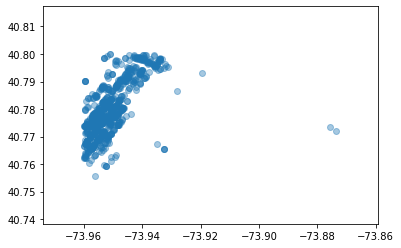

In [122]:
dd = restaurant_data[
    ( restaurant_data.latitudes >= 40.74 ) &
    ( restaurant_data.latitudes <= 40.8 ) &
    ( restaurant_data.longitudes >= -73.96 )
]

plt.scatter(dd.longitudes, dd.latitudes, alpha=0.4)
# plt.scatter(restaurant_data.longitudes, restaurant_data.latitudes, alpha=0.4)

In [92]:
len(restaurant_data)

17382

In [149]:
revised_addresses = []
revised_latitudes = []
revised_longitudes = []

In [151]:
# bad_data = restaurant_data[
#     ( restaurant_data.latitudes < 40 ) |
#     ( restaurant_data.latitudes > 40.9 ) |
#     ( restaurant_data.longitudes < -74.05 )
# ]

bad_data = restaurant_data[
    ( restaurant_data.latitudes >= 40.74 ) &
    ( restaurant_data.latitudes <= 40.8 ) &
    ( restaurant_data.longitudes >= -73.96 )
]

for cur_index, revised_address in enumerate(bad_data.address):
    if cur_index < len(revised_addresses): continue
    (revised_latitude, revised_longitude) = gc(f"{revised_address} new york")

    revised_addresses.append(revised_address)
    revised_latitudes.append(revised_latitude)
    revised_longitudes.append(revised_longitude)

assert revised_addresses == list(bad_data.address)

assert len(revised_addresses) == len(revised_latitudes)
assert len(revised_addresses) == len(revised_longitudes)


geocoded 17383: 1980 3Rd Ave Manhattan, 10029 new york (nominatim - 1.5s)
geocoded 17383: 2291 2Nd Ave Manhattan, 10035 new york (openmapquest - 0.5s)
geocoded 17383: 1637 Park Ave Manhattan, 10029 new york (bing - 0.7s)
geocoded 17383: 1345 2Nd Ave Manhattan, 10021 new york (arcgis - 0.5s)
geocoded 17383: 1154 1St Avenue Manhattan, 10065 new york (openmapquest - 0.4s)
geocoded 17383: 1817 2Nd Ave Manhattan, 10128 new york (nominatim - 1.2s)
geocoded 17383: 1771 1St Ave Manhattan, 10128 new york (openmapquest - 0.5s)
geocoded 17383: 1531 York Ave Manhattan, 10028 new york (nominatim - 1.6s)
geocoded 17383: 168 E 81St St Manhattan, 10028 new york (bing - 0.5s)
geocoded 17383: 170 E 110Th St Manhattan, 10029 new york (arcgis - 0.6s)
geocoded 17383: 2245 1St Ave Manhattan, 10029 new york (bing - 0.5s)
geocoded 17383: 308 E 116Th St Manhattan, 10029 new york (arcgis - 0.6s)
geocoded 17383: 1538 3Rd Ave Manhattan, 10028 new york (nominatim - 1.3s)
geocoded 17383: 1471 1 Avenue Manhattan, 10

geocoded 17383: 1556 2Nd Ave Manhattan, 10028 new york (bing - 0.5s)
geocoded 17383: 2126 2Nd Avenue Manhattan, 10029 new york (openmapquest - 0.5s)
geocoded 17383: 2270 1St Ave Manhattan, 10035 new york (nominatim - 0.8s)
geocoded 17383: 1469 2Nd Ave Manhattan, 10075 new york (arcgis - 0.5s)
geocoded 17383: 1389 Madison Ave Manhattan, 10029 new york (arcgis - 1.0s)
geocoded 17383: 1580 York Avenue Manhattan, 10028 new york (arcgis - 0.5s)
geocoded 17383: 1484 2Nd Ave Manhattan, 10075 new york (nominatim - 0.8s)
geocoded 17383: 2100 2Nd Ave Manhattan, 10029 new york (openmapquest - 0.5s)
geocoded 17383: 1536 3Rd Ave Manhattan, 10028 new york (nominatim - 0.9s)
geocoded 17383: 1413 Madison Avenue Manhattan, 10029 new york (arcgis - 0.5s)
geocoded 17383: 355 E 86Th St Manhattan, 10028 new york (arcgis - 1.3s)
geocoded 17383: 609 Main St Manhattan, 10044 new york (openmapquest - 0.5s)
geocoded 17383: 1497 3 Avenue Manhattan, 10028 new york (arcgis - 0.5s)
geocoded 17383: 1288-1290 1St Ave

geocoded 17383: 1668 3Rd Ave Manhattan, 10128 new york (openmapquest - 0.4s)
geocoded 17383: 1370 York Avenue Manhattan, 10021 new york (openmapquest - 0.4s)
geocoded 17383: 1361 First Avenue Manhattan, 10021 new york (arcgis - 0.6s)
geocoded 17383: 1555 2Nd Ave Manhattan, 10028 new york (openmapquest - 0.4s)
geocoded 17383: Central Terminal Building Manhattan, 11371 new york (arcgis - 0.8s)
geocoded 17383: 1834 2Nd Ave Manhattan, 10128 new york (bing - 0.5s)
geocoded 17383: 1640 2Nd Ave Manhattan, 10028 new york (bing - 0.6s)
geocoded 17383: 42 Broadway Manhattan, 10004 new york (arcgis - 0.5s)
geocoded 17383: 174 East 82 Street Manhattan, 10028 new york (bing - 0.5s)
geocoded 17383: 1200 Lexington Ave Manhattan, 10028 new york (bing - 0.5s)
geocoded 17383: 0 Wards Island/2Fl Manhattan, 10057 new york (bing - 0.4s)
geocoded 17383: 129 E 102Nd St Manhattan, 10029 new york (openmapquest - 0.5s)
geocoded 17383: 1260 Lexington Ave Manhattan, 10028 new york (nominatim - 0.9s)
geocoded 1738

geocoded 17383: 1580 1St Ave Manhattan, 10028 new york (openmapquest - 0.5s)
geocoded 17383: 2146 2 Avenue Manhattan, 10029 new york (arcgis - 0.5s)
geocoded 17383: 163 East 116 Street Manhattan, 10029 new york (bing - 0.6s)
geocoded 17383: 1626 2Nd Ave Manhattan, 10028 new york (arcgis - 0.5s)
geocoded 17383: 1569 Lexington Ave Manhattan, 10029 new york (openmapquest - 0.4s)
geocoded 17383: 41 East 78 Street Manhattan, 10075 new york (arcgis - 0.5s)
geocoded 17383: 19 East 69 Street Manhattan, 10021 new york (arcgis - 0.5s)
geocoded 17383: 1267 1 Avenue Manhattan, 10065 new york (arcgis - 1.3s)
geocoded 17383: 1439 York Avenue Manhattan, 10075 new york (bing - 0.5s)
geocoded 17383: 1131 Madison Avenue Manhattan, 10028 new york (bing - 0.5s)
geocoded 17383: 252 East 77 Street Manhattan, 10075 new york (bing - 0.5s)
geocoded 17383: 1270 1 Avenue Manhattan, 10065 new york (bing - 0.5s)
geocoded 17383: 1309 Lexington Avenue Manhattan, 10128 new york (nominatim - 0.9s)
geocoded 17383: 1399

geocoded 17383: 1574 1St Ave Manhattan, 10028 new york (nominatim - 0.9s)
geocoded 17383: 1144 Lexington Ave Manhattan, 10075 new york (nominatim - 0.9s)
geocoded 17383: 1728 Madison Avenue Manhattan, 10029 new york (bing - 0.8s)
geocoded 17383: 422 East 75 Street Manhattan, 10021 new york (arcgis - 0.5s)
geocoded 17383: 1568 3Rd Ave Manhattan, 10128 new york (arcgis - 0.5s)
geocoded 17383: 242 East 79 Street Manhattan, 10075 new york (bing - 0.7s)
geocoded 17383: 135 E 110Th St Manhattan, 10029 new york (arcgis - 0.5s)
geocoded 17383: 359 E 68Th St Manhattan, 10065 new york (bing - 0.7s)
geocoded 17383: 358 E 112Th St Manhattan, 10029 new york (arcgis - 0.7s)
geocoded 17383: 1277 1St Ave Manhattan, 10065 new york (arcgis - 1.3s)
geocoded 17383: 1295 Madison Avenue Manhattan, 10128 new york (openmapquest - 0.4s)
geocoded 17383: 2119 1St Ave Manhattan, 10029 new york (bing - 0.8s)
geocoded 17383: 179 East 86 Street Manhattan, 10028 new york (arcgis - 0.5s)
geocoded 17383: 1404 3 Avenue 

geocoded 17383: 245 E 80Th St Manhattan, 10075 new york (arcgis - 0.5s)
geocoded 17383: 350 5Th Ave Manhattan, 10118 new york (arcgis - 0.6s)
geocoded 17383: 245 E 93Rd St Manhattan, 10128 new york (nominatim - 1.2s)
geocoded 17383: 400 East 90 Street Manhattan, 10128 new york (arcgis - 0.9s)
geocoded 17383: 350 5Th Ave Manhattan, 10118 new york (arcgis - 0.9s)
geocoded 17383: 1485 2Nd Ave Manhattan, 10075 new york (openmapquest - 0.5s)
geocoded 17383: 1657 Madison Ave Manhattan, 10029 new york (openmapquest - 0.7s)
geocoded 17383: 1705 1St Ave Manhattan, 10128 new york (openmapquest - 0.4s)
geocoded 17383: 1885 3 Avenue Manhattan, 10029 new york (bing - 1.2s)
geocoded 17383: 1434 Lexington Avenue Manhattan, 10128 new york (arcgis - 0.5s)
geocoded 17383: 1269 1 Avenue Manhattan, 10065 new york (bing - 0.5s)
geocoded 17383: 11 Broadway Manhattan, 10004 new york (bing - 0.7s)
geocoded 17383: 563 Lenox Avenue Manhattan, 10037 new york (bing - 0.8s)
geocoded 17383: 1256 Lexington Avenue Ma

geocoded 17383: 1742 2 Avenue Manhattan, 10128 new york (bing - 0.9s)
geocoded 17383: 2109 1St Ave Manhattan, 10029 new york (openmapquest - 0.5s)
geocoded 17383: 2308 1 Avenue Manhattan, 10035 new york (arcgis - 0.5s)
geocoded 17383: 1570 3Rd Ave Manhattan, 10128 new york (openmapquest - 0.4s)
geocoded 17383: 21 Lenox Ave Manhattan, 10026 new york (bing - 0.7s)
geocoded 17383: 1415 2Nd Ave Manhattan, 10021 new york (bing - 0.6s)
geocoded 17383: 695 Park Ave Manhattan, 10065 new york (nominatim - 0.9s)
geocoded 17383: 328 E 78Th St Manhattan, 10075 new york (openmapquest - 0.4s)
geocoded 17383: 2331 1St Ave Manhattan, 10035 new york (nominatim - 1.1s)
geocoded 17383: 305 E 115Th St Manhattan, 10029 new york (nominatim - 0.9s)
geocoded 17383: 1481 York Avenue Manhattan, 10075 new york (arcgis - 0.5s)
geocoded 17383: 1764 1St Ave Manhattan, 10128 new york (openmapquest - 0.4s)
geocoded 17383: 404 E 69Th St Manhattan, 10021 new york (nominatim - 1.0s)
geocoded 17383: 501 1/2 East 83 Stree

geocoded 17383: 1764 1St Ave Manhattan, 10128 new york (arcgis - 0.5s)
geocoded 17383: 1619 York Ave Manhattan, 10028 new york (arcgis - 1.3s)
geocoded 17383: 406 E 73Rd St Manhattan, 10021 new york (bing - 0.6s)
geocoded 17383: 1457 3Rd Ave Manhattan, 10028 new york (bing - 0.6s)
geocoded 17383: 2296 1St Ave Manhattan, 10035 new york (openmapquest - 0.4s)
geocoded 17383: 11 Broadway Manhattan, 10004 new york (bing - 0.5s)
geocoded 17383: 2327 1St Ave Manhattan, 10035 new york (bing - 0.5s)
geocoded 17383: 354 E 78Th St Manhattan, 10075 new york (arcgis - 0.6s)
geocoded 17383: 118 E 116Th St Manhattan, 10029 new york (arcgis - 0.5s)
geocoded 17383: 1928 3Rd Ave Manhattan, 10029 new york (bing - 0.9s)
geocoded 17383: 1302 Madison Ave Manhattan, 10128 new york (arcgis - 0.5s)
geocoded 17383: 2154 3Rd Ave Manhattan, 10035 new york (nominatim - 0.9s)
geocoded 17383: 42 Broadway Manhattan, 10004 new york (bing - 0.8s)
geocoded 17383: 42 Broadway Manhattan, 10004 new york (nominatim - 0.9s)


In [135]:
assert list(bad_data["address"]) == revised_addresses

for cur_index, revised_address in enumerate(revised_addresses):
    cur_address = restaurant_data[restaurant_data.address == revised_address]
    
    print([revised_latitudes[cur_index],revised_longitudes[cur_index]])
    assert revised_latitudes[cur_index] >= 40
    assert revised_latitudes[cur_index] <= 40.9
    assert revised_longitudes[cur_index] >= -74.05
    
    restaurant_data.loc[restaurant_data.address == revised_address, 'latitudes'] = revised_latitudes[cur_index]
    restaurant_data.loc[restaurant_data.address == revised_address, 'longitudes'] = revised_longitudes[cur_index]
    
new_bad_data = restaurant_data[
    ( restaurant_data.latitudes < 40 ) |
    ( restaurant_data.latitudes > 40.9 ) |
    ( restaurant_data.longitudes < -74.05 )
]

new_bad_data


[40.774694, -73.954634]
[40.76543705, -73.9573843826711]
[40.76958, -73.95447]
[40.787239446408435, -73.95409220954556]
[40.76880115574906, -73.9603023194193]
[40.76759033, -73.95938133]
[40.78925, -73.94057]
[40.775335, -73.951229]
[40.79902310558934, -73.94125418191963]
[40.77009, -73.95765]
[40.7934543, -73.94361055]
[40.797996068280526, -73.93711427001448]
[40.798966, -73.9431794]
[40.7680613, -73.9592321369079]
[40.76219745, -73.959753243559]
[40.78303676198031, -73.94804788184821]
[40.780455188281614, -73.9468114554688]
[40.7727264, -73.949777]
[40.7758950170969, -73.9572171462319]
[40.794232, -73.94359]
[40.79564, -73.93589]
[40.796553, -73.937406]
[40.77931, -73.95386]
[40.77084888826895, -73.95383654836986]
[40.7876512, -73.947772]
[40.798500537862715, -73.94114238885139]
[40.79473, -73.94259]
[40.774964709716194, -73.95394513360317]
[40.792415, -73.9522651]
[40.7723406, -73.9552385636426]
[40.78281, -73.94526]
[40.7622896, -73.9591177516627]
[40.77576, -73.95694]
[40.79575118

[40.766248556380205, -73.95722809745217]
[40.79194, -73.94513]
[40.77751357985552, -73.95192362014194]
[40.772571, -73.954964]
[40.77121803636206, -73.95193806078125]
[40.7704002061928, -73.95401111715265]
[40.798244, -73.941775]
[40.792718, -73.945756]
[40.79782697845757, -73.93953156782695]
[40.774312, -73.962971]
[40.774312, -73.962971]
[40.77801, -73.94832]
[40.7672615663048, -73.95896307108669]
[40.77646885, -73.9531884]
[40.7748781, -73.9542893]
[40.771240293449, -73.95650593155828]
[40.77951, -73.95033]
[40.7680904, -73.9591107]
[40.798707, -73.942436]
[40.7902778, -73.9597222]
[40.774647, -73.958785]
[40.77456828949135, -73.95096127115636]
[40.777196442965, -73.95600108653097]
[40.794272050938005, -73.93985474161249]
[40.77523355829959, -73.95374934170003]
[40.78028, -73.94667]
[40.77558, -73.95658]
[40.78490431012907, -73.95578098970674]
[40.79115005017239, -73.93903425476513]
[40.78355, -73.95074]
[40.7714868, -73.9530897]
[40.776398, -73.952014]
[40.78077, -73.95432]
[40.777

[40.74840136199598, -73.98466906599461]
[40.7723592, -73.9561364860837]
[40.7963546, -73.9472131444864]
[40.77855535, -73.9485889134743]
[40.79035, -73.94534]
[40.78424452149474, -73.95219516483492]
[40.76545072773146, -73.95780546560908]
[40.77247948691886, -73.94972216135353]
[40.81637667, -73.93906833]
[40.7787046, -73.9564358]
[40.798756, -73.952794]
[40.76105503235937, -73.950761817284]
[40.7877554, -73.9541141845869]
[40.769310124115655, -73.95203312921306]
[40.77641, -73.95304]
[40.77509, -73.95047]
[40.7911284894468, -73.95139417859784]
[40.7696589, -73.957961]
[40.76898593853723, -73.95455570048202]
[40.7738707, -73.9581174504769]
[40.77155265095217, -73.95309008206061]
[40.771246, -73.952939]
[40.77530402179845, -73.953542641598]
[40.76851652356885, -73.95540792682738]
[40.774511, -73.948429]
[40.759328, -73.970529]
[40.77788312981747, -73.95474268313316]
[40.7671, -73.95673]
[40.787248, -73.9516066106032]
[40.784485, -73.95585]
[40.79044, -73.94572]
[40.78655639930081, -73.9

[40.76309013102114, -73.95640962347356]
[40.70611210535565, -74.01296549750998]
[40.790865, -73.947459]


IndexError: list index out of range

In [157]:
restaurant_data.to_pickle("./data/pickles/restaurant_data.pkl")

In [156]:
restaurant_data

,name,cuisine,address,latitudes,longitudes
0,& Pizza,Pizza,"15 W 28Th St Manhattan, 10001",40.745193,-73.988235
1,& Pizza,Pizza,"740 Broadway Manhattan, 10003",40.729903,-73.992764
2,1 2 3 Burger Shot Beer,American,"738 10 Avenue Manhattan, 10019",40.764830,-73.991460
3,#1 Chinese Restaurant,Chinese,"825 W 181St St Manhattan, 10033",40.849840,-73.934966
4,1 Darbar,Indian,"152 East 46 Street Manhattan, 10017",40.753771,-73.973847
...,...,...,...,...,...
17377,Tommy'S Tavern,American,"1041 Manhattan Avenue Brooklyn, 11222",40.734324,-73.955094
17378,Tongkatsu,Japanese,"137 Rivington St Manhattan, 10002",40.719383,-73.986427
17379,Union Square Burger,American,"729 8Th Ave Manhattan, 10036",40.759706,-73.988062
17380,Vintry,American,"57 Stone Street Manhattan, 10004",40.704458,-74.010277
